In [2]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.1 MB/s eta 0:00:00


In [3]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load the pre-trained tokenizer and model
model_name = "bert-base-multilingual-cased"  # You can choose a different model if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


In [28]:
def extract_embedding(ukrainian_sentences):

  # Tokenize all sentences and convert them to input IDs
  tokenized_inputs = tokenizer(ukrainian_sentences, padding=True, truncation=True, return_tensors="pt")

  # Pass the input IDs through the model to get embeddings
  with torch.no_grad():
      outputs = model(**tokenized_inputs)

  # Extract embeddings from the output
  embeddings = outputs.last_hidden_state.mean(dim=1)  # Average the embeddings over all tokens

  return list(embeddings)

from sklearn.metrics.pairwise import cosine_similarity
def calculate_text_similarity(embedding1, embedding2):
    # Reshape the embeddings to be 1D arrays
    embedding1 = embedding1.reshape(1, -1)
    embedding2 = embedding2.reshape(1, -1)

    # Calculate the cosine similarity using NumPy
    similarity = cosine_similarity(embedding1, embedding2)

    return similarity[0, 0]

In [57]:
def process(df):
  # extract embedding from summary
  summary_sentences = df['summary'].tolist()
  summary_embeddings = extract_embedding(summary_sentences)
  df['summary_embeddings'] = summary_embeddings

  # extract embedding from topic
  topic_sentences = list(df['predicted_class'].unique())
  topic_embeddings = extract_embedding(topic_sentences)
  topic_embedding_map = dict(map(lambda i,j : (i,j) , topic_sentences, topic_embeddings))
  df['topic_embeddings'] = df['predicted_class'].apply(lambda x: topic_embedding_map[x])

  # calculate text similariy
  df['coverage_rate'] = df[['summary_embeddings', 'topic_embeddings']].apply(lambda x: calculate_text_similarity(x['summary_embeddings'], x['topic_embeddings']), axis=1)
  return df


In [54]:
def analysis(df):
  print("average coverage rate is: {}%".format( round(df['coverage_rate'].mean()*100, 4) ))
  df['coverage_rate'].hist()

# summary analysis (model generated by other paper)

In [58]:
import pandas as pd
df_mt5_large = pd.read_csv("prediction_mT5-sum-news-ua.csv")
df_mt5_large = process(df_mt5_large)


average coverage rate is: 30.2041%


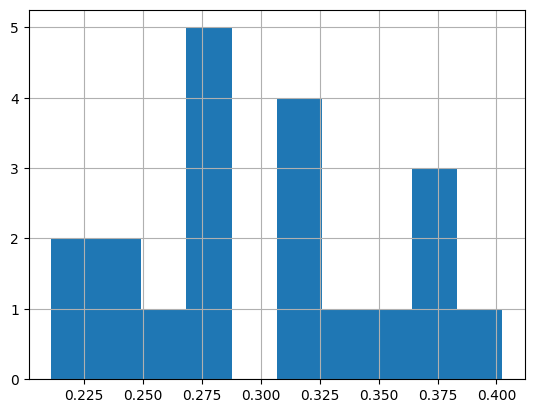

In [59]:
# show distribution
analysis(df_mt5_large)

In [60]:
df_mt5_large[['summary', 'predicted_class', 'coverage_rate']]

,summary,predicted_class,coverage_rate
0,швейцарський червоний хрест спільно з швейцарс...,Volunteering,0.280093
1,сервіси допомоги мігрантам у канаді підтримуют...,Volunteering,0.402388
2,швейцарія дозволяє самозайнятості в країні зі ...,Integration,0.259173
3,група допомоги швейцарцям у пошуку житла та ро...,Volunteering,0.333447
4,швейцарська влада надала статус захисту s для ...,Volunteering,0.274428
5,genius space відкриває для українців безкоштов...,Education,0.379351
6,у французькому місті сен-преx відкрили бутік д...,Immigration,0.312603
7,у київській обласній дитячій лікарні «академік...,Education,0.236263
8,у швейцарії 11 червня асоціація «українки швей...,Education,0.211033
9,у німецькому місті генєві відкрили художню гру...,Education,0.272107


# summary analysis (our own model)

In [32]:
import pandas as pd
df_mt5_base = pd.read_csv("prediction_uk-mt5-base-xlsum-v3.csv")
df_mt5_base = process(df_mt5_base)

average coverage rate is: 30.656%


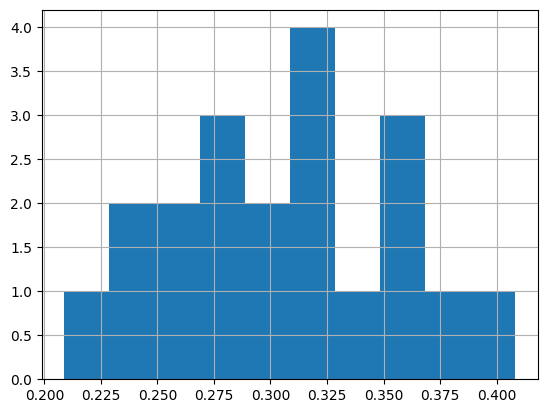

In [56]:
# show distribution
analysis(df_mt5_base)